In [1]:
import os
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from itertools import product
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from datasets import available_datasets

sns.set(style='ticks', palette='Set2')
sns.despine()
sns.set_context("talk")
pd.set_option('display.width', 2000)

<Figure size 432x288 with 0 Axes>

## Helper Functions

In [2]:
def confidence_interval(data, func=np.mean, size=1000, ci=95, seed=12345):
    bs_replicates = sns.algorithms.bootstrap(data, func=func, n_boot=size, seed=seed)
    bounds = sns.utils.ci(bs_replicates, ci)
    return (bounds[1] - bounds[0]) / 2


def read_logs(path, task, **params):
    df_results = pd.DataFrame()
    for config in tqdm(list(product(*params.values()))):
        experiment_file = os.path.join(
            path,
            f'task:{task}',
            *[f'{key}:{value}' for key, value in zip(params.keys(), config)],
            'metrics.csv'
        )
        df = pd.read_csv(experiment_file)
        for key, value in zip(params.keys(), config):
            df[key] = value
        df_results = df_results.append(df, ignore_index=True)
    return df_results


def export_figure(path, df, x, y, hue, col, ci=95, prefix=''):
    if not os.path.exists(path):
        os.makedirs(path)
    
    if ci in df.columns:
        output = [x, y, ci]
    elif ci == 'sd':
        df = df.groupby([col, hue, x])[y].agg(['mean', np.std]).reset_index()
        output = [x, 'mean', 'std']
    else:
        df = df.groupby([col, hue, x]).agg(mean=(y,'mean'), std=(y, lambda a: confidence_interval(a, ci=ci))).reset_index()
        output = [x, 'mean', 'std']
        
        
    df['filename'] = df[[col, hue]].apply(
        lambda row: f'{prefix},' + ','.join(
            [f'{key}={val}' for key, val in row.iteritems()]
        ) + f',x={x},y={y}.txt', axis=1
    )
    df.groupby('filename').apply(
        lambda row: row[output].to_csv(
            os.path.join(path, row['filename'].unique().item()), 
            index=None, 
            sep=' '
        )
    )
    
    
def to_latex(df):
    df.insert(loc=1, column='|', value='')
    df.insert(loc=6, column='||', value='')
    txt = df.to_latex(escape=False)
    txt = txt.replace('$\pm$ ', '$\pm$~')
    txt = txt.replace(r'\\', r'\\ \rule{0pt}{4ex}')
    return txt

In [3]:
results_path = 'results'
datasets = available_datasets()

## Analysis of the utility-privacy trade-off

In [4]:
epsilons = [0.1, 0.5, 1.0, 2.0]

df_lpgnn = read_logs(
    path=results_path,
    task='train',
    dataset=datasets, 
    labelrate=[1.0],
    method=['mbm'], 
    eps=epsilons,
    step=[1,2,4,8,16,32],
    agg=['gcn'],
    selfloops=[False],
)

df_gcn = read_logs(
    path=results_path,
    task='train',
    dataset=datasets, 
    labelrate=[1.0],
    method=['raw', 'rnd', 'ohd'], 
    eps=[0.0],
    step=[1],
    agg=['gcn'],
    selfloops=[True],
)


names = {
    'raw': '1-GCN+Raw',
    'mbm': '2-LPGNN',
    'rnd': '3-GCN+Rnd',
    'ohd': '4-GCN+Ohd',
    'cora': '1-Cora',
    'citeseer': '2-Citeseer',
    'pubmed': '3-Pubmed',
    'facebook': '4-Facebook',
    'github': '5-Github',
    'lastfm': '6-LastFM'
}

df_mean = df_lpgnn.groupby(['dataset', 'eps', 'step'])['test_acc'].mean().reset_index()
idx = df_mean.groupby(['dataset', 'eps'])['test_acc'].transform(max) == df_mean['test_acc']
df_max = df_mean[idx]
df_final = df_lpgnn.merge(df_max.drop(columns='test_acc'), on=['dataset', 'eps', 'step'], how='inner')
data = df_final.append(df_gcn, ignore_index=True)

data = data.groupby(['dataset', 'method', 'eps']).agg({'test_acc': ['mean', 'std']}).reset_index()
data = data.replace(names)
data.columns = ['Dataset', 'Method', '$\epsilon$', 'mean', 'std']
data['result'] = data[['mean', 'std']].apply(lambda row: '%.1f $\pm$ %.1f' % (row['mean'], row['std']), axis=1)
data = data.drop(columns=['mean', 'std']).set_index(['Dataset', 'Method', '$\epsilon$'])
data = data.unstack(level=0).T
data = data.rename(index=lambda name: name[2:] if name[1] == '-' else name)
data = data.rename(columns=lambda name: name[2:] if str(name)[1] == '-' else name)
data.index = data.index.droplevel()
data
# print(to_latex(data))

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Method             GCN+Raw           LPGNN                                                         GCN+Rnd         GCN+Ohd
$\epsilon$             0.0             0.1             0.5             1.0             2.0             0.0             0.0
Dataset                                                                                                                   
Cora        85.0 $\pm$ 0.5  84.6 $\pm$ 0.5  84.6 $\pm$ 0.6  84.6 $\pm$ 0.6  84.6 $\pm$ 0.6  78.1 $\pm$ 1.3  58.4 $\pm$ 0.7
Citeseer    73.7 $\pm$ 0.5  68.6 $\pm$ 0.8  68.4 $\pm$ 0.7  68.6 $\pm$ 0.9  68.6 $\pm$ 0.8  58.3 $\pm$ 4.1  38.5 $\pm$ 0.9
Pubmed      87.0 $\pm$ 0.2  82.1 $\pm$ 0.2  82.2 $\pm$ 0.3  82.2 $\pm$ 0.3  82.2 $\pm$ 0.3  56.5 $\pm$ 2.2  62.4 $\pm$ 0.9
Facebook    94.8 $\pm$ 0.1  94.0 $\pm$ 0.1  94.0 $\pm$ 0.2  94.0 $\pm$ 0.2  94.0 $\pm$ 0.2  40.6 $\pm$ 1.2  79.2 $\pm$ 0.3
Github      86.7 $\pm$ 0.2  85.9 $\pm$ 0.1  85.9 $\pm$ 0.2  85.9 $\pm$ 0.2  85.9 $\pm$ 0.1  74.4 $\pm$ 0.1  84.0 $\pm$ 0.1
LastFM      87.7 $\pm$ 0.4  86.1 $\pm$ 0.3  86.1 $\pm$ 0.3  86.1 $\pm$ 0.2  86.1 $\pm$ 0.3  25.2 $\pm$ 7.1  70.6 $\pm$ 0.5

## Studying the effect of multi-bit mechanism

  0%|          | 0/72 [00:00<?, ?it/s]

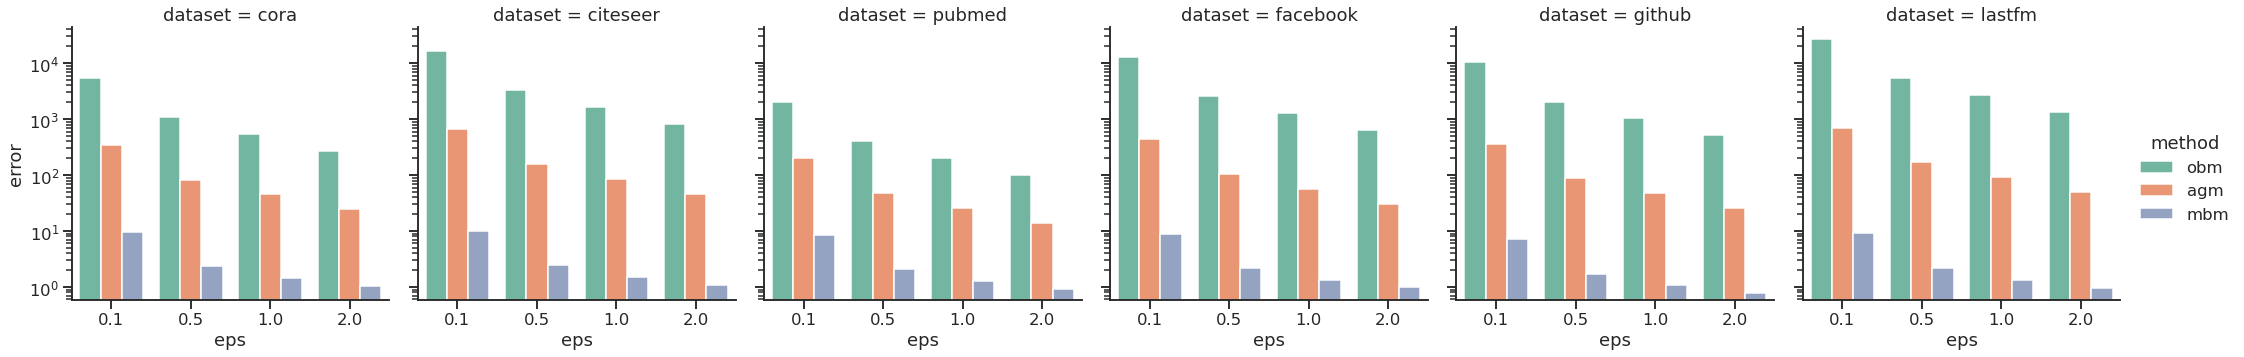

In [5]:
df_error = read_logs(
    path=results_path, 
    task='error', 
    dataset=datasets, 
    method=['obm', 'agm', 'mbm'], 
    eps=[0.1, 0.5, 1.0, 2.0], 
    agg=['gcn'], 
)

ax = sns.catplot(
    kind='bar', data=df_error, x='eps', y='error', hue='method', col='dataset', ci=None, sharey=True
)

ax.set(yscale='log')

export_figure(
    path='figures', df=df_error, x='eps', y='error', hue='method', 
    col='dataset', ci='std', prefix='error'
)

  0%|          | 0/48 [00:00<?, ?it/s]

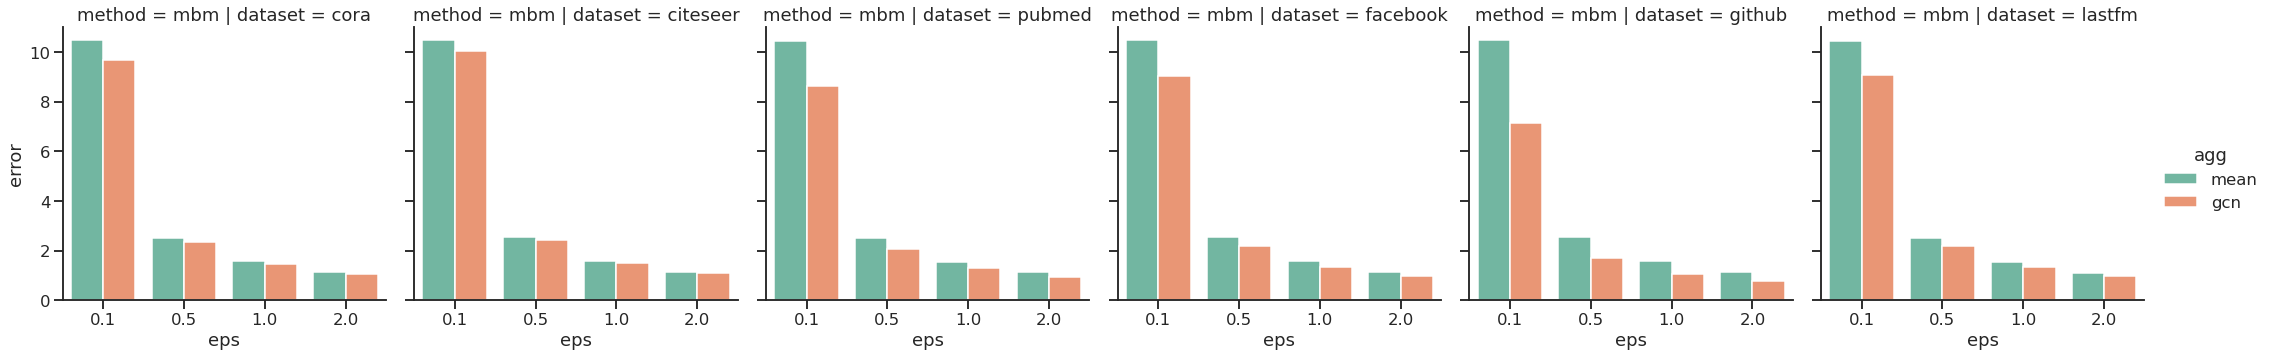

In [6]:
df_error = read_logs(
    path=results_path, 
    task='error', 
    dataset=datasets, 
    method=['mbm'], 
    eps=[0.1, 0.5, 1.0, 2.0], 
    agg=['mean', 'gcn'], 
)

ax = sns.catplot(
    kind='bar', data=df_error, x='eps', y='error', hue='agg', col='dataset', row='method', ci=None, sharey=True
)

export_figure(
    path='figures', df=df_error, x='eps', y='error', hue='agg', 
    col='dataset', ci='std', prefix='error'
)

## Studying the effect of KProp

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

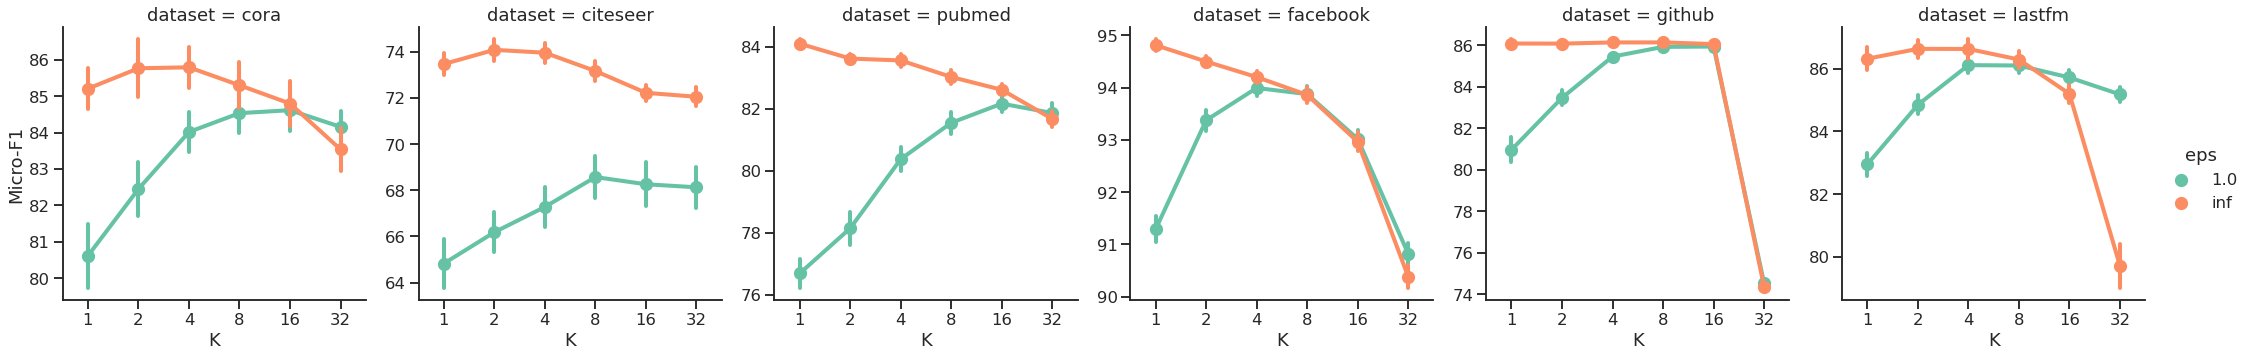

In [7]:
epsilons = [1.0]
hops = [1, 2, 4, 8, 16, 32]

df_lpgnn = read_logs(
    path=results_path,
    task='train',
    dataset=datasets, 
    labelrate=[1.0],
    method=['mbm'], 
    eps=epsilons,
    step=hops,
    agg=['gcn'],
    selfloops=[False],
)

df_gcn = read_logs(
    path=results_path,
    task='train',
    dataset=datasets, 
    labelrate=[1.0],
    method=['raw'], 
    eps=[0.0],
    step=hops,
    agg=['gcn'],
    selfloops=[False],
)

data = df_lpgnn.append(df_gcn, ignore_index=True)
data.loc[data['eps'] == 0.0,'eps'] = np.inf

ax = sns.catplot(
    kind='point', data=data, x='step', y='test_acc', hue='eps', col='dataset', ci='sd',
    sharex=False, sharey=False,
)

ax.set_ylabels('Micro-F1')
ax.set_xlabels('K')

export_figure(path='figures', df=data, x='step', y='test_acc', hue='eps', col='dataset', prefix='train', ci='sd')

  0%|          | 0/72 [00:00<?, ?it/s]

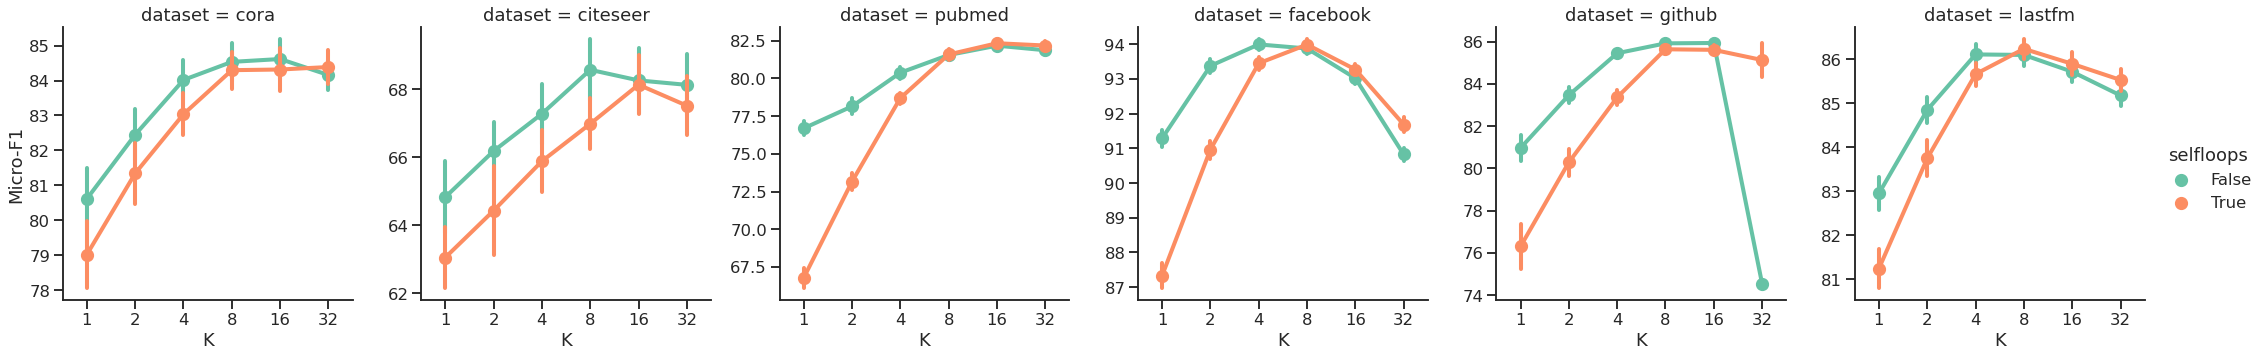

In [8]:
epsilons = [1.0]
hops = [1, 2, 4, 8, 16, 32]

data = read_logs(
    path=results_path,
    task='train',
    dataset=datasets,
    labelrate=[1.0],
    method=['mbm'], 
    eps=epsilons,
    step=hops,
    agg=['gcn'],
    selfloops=[False, True],
)

ax = sns.catplot(
    kind='point', data=data, x='step', y='test_acc', hue='selfloops', col='dataset', ci='sd',
    sharex=False, sharey=False,
)

ax.set_ylabels('Micro-F1')
ax.set_xlabels('K')

export_figure(path='figures', df=data, x='step', y='test_acc', hue='selfloops', col='dataset', prefix='train', ci='sd')

## Effect of label rate

  0%|          | 0/90 [00:00<?, ?it/s]

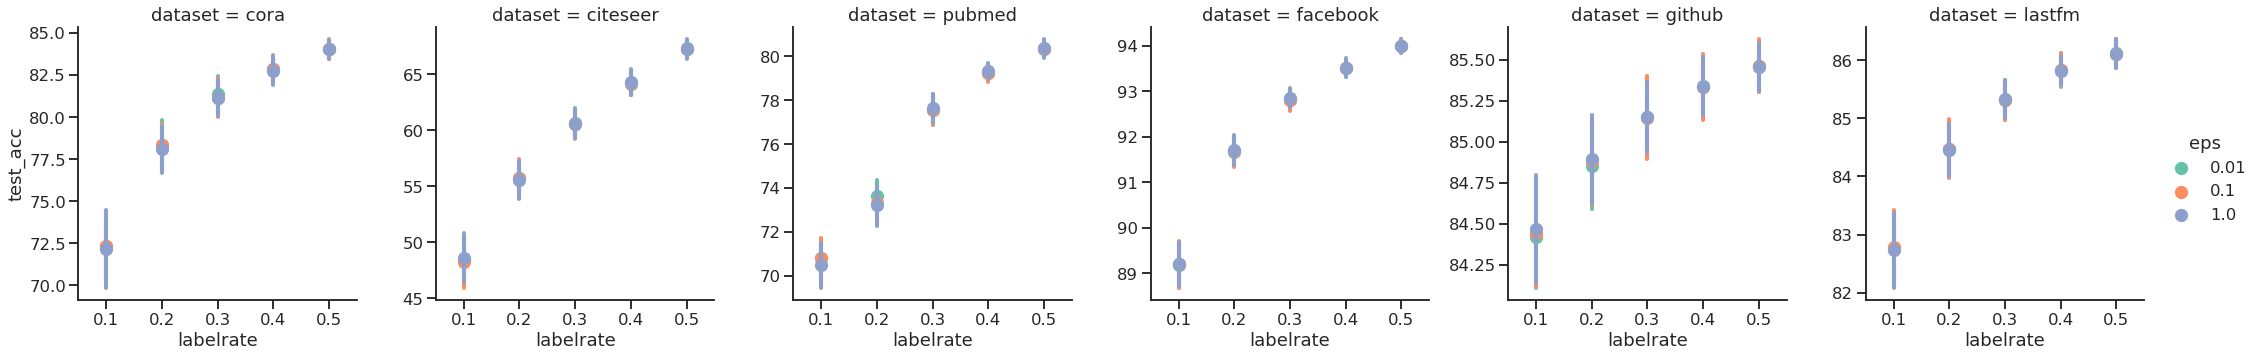

In [9]:
data = read_logs(
    path=results_path,
    task='train',
    dataset=datasets, 
    labelrate=[0.2, 0.4, 0.6, 0.8, 1.0],
    method=['mbm'], 
    eps=[0.01, 0.1, 1.0],
    step=[4],
    agg=['gcn'],
    selfloops=[False],
)

data['labelrate'] /= 2

ax = sns.catplot(
    kind='point', data=data, x='labelrate', y='test_acc', hue='eps', col='dataset', ci='sd',
    sharex=False, sharey=False, join=False
)

export_figure(path='figures', df=data, x='labelrate', y='test_acc', hue='eps', col='dataset', prefix='train', ci='sd')

  0%|          | 0/90 [00:00<?, ?it/s]

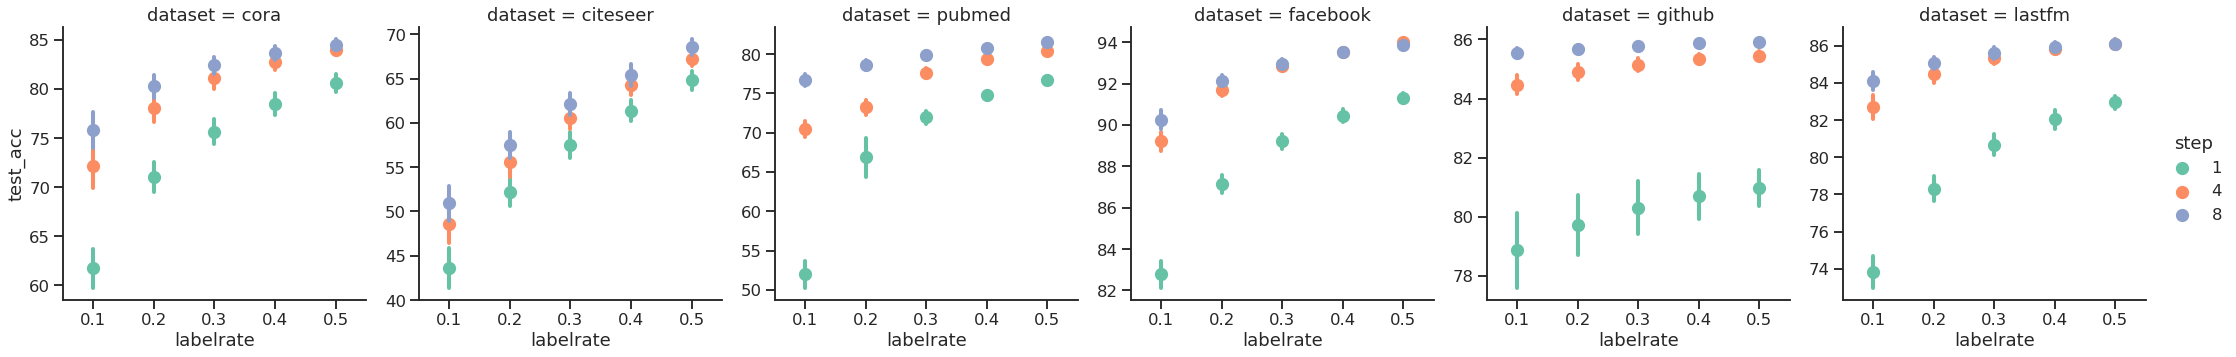

In [10]:
data = read_logs(
    path=results_path,
    task='train',
    dataset=datasets, 
    labelrate=[0.2, 0.4, 0.6, 0.8, 1.0],
    method=['mbm'], 
    eps=[1.0],
    step=[1, 4, 8],
    agg=['gcn'],
    selfloops=[False],
)

data['labelrate'] /= 2

ax = sns.catplot(
    kind='point', data=data, x='labelrate', y='test_acc', hue='step', col='dataset', ci='sd',
    sharex=False, sharey=False, join=False
)

export_figure(path='figures', df=data, x='labelrate', y='test_acc', hue='step', col='dataset', prefix='train', ci='sd')